# Online Multiclass Logistic Regression using CMGF

##0. Imports

In [1]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging, sys, warnings, os

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

# if not sys.warnoptions:
#     warnings.simplefilter("ignore")
#     os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [2]:
try:
    from ssm_jax.cond_moments_gaussian_filter.inference import *
    from ssm_jax.cond_moments_gaussian_filter.containers import *
except ModuleNotFoundError:
    print('installing ssm_jax')
    %pip install -qq git+https://github.com/probml/ssm-jax.git
    from ssm_jax.cond_moments_gaussian_filter.inference import *
    from ssm_jax.cond_moments_gaussian_filter.containers import *

installing ssm_jax
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 145 kB 2.8 MB/s 
     |████████████████████████████████| 180 kB 37.6 MB/s 
     |████████████████████████████████| 106 kB 50.1 MB/s 
     |████████████████████████████████| 85 kB 3.4 MB/s 
     |████████████████████████████████| 128 kB 48.3 MB/s 
     |████████████████████████████████| 217 kB 45.4 MB/s 
     |████████████████████████████████| 51 kB 3.7 MB/s 


In [3]:
from warnings import simplefilter

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as jr
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

## 1. CMGF Model for Online Multiclass Logistic Regression

Note that the moments of a (one-hot-encoded) categorical distribution with $K$ possible classes are as follows:

$$\mathbb{E}[\vec{y}|\vec{x}, \textbf{W}] =  \begin{pmatrix} \sigma_2(\textbf{W}^T\vec{x}) \\ \sigma_3(\textbf{W}^T\vec{x}) \\ \vdots \\ \sigma_K(\textbf{W}^T\vec{x}) \end{pmatrix}
$$
$$Cov[\vec{y}|\vec{x}, \textbf{W}] = \begin{pmatrix} p_2 (1 - p_2) & -p_2 p_3 & \dots & -p_2 p_K \\
-p_2 p_3 & p_3 (1 - p_3) & \dots  & -p_3 p_K \\
\vdots & \vdots & \ddots & \vdots \\
-p_2 p_K & -p_3 p_K & \dots & p_K (1 - p_K)
 \end{pmatrix}$$
where $\vec{\sigma}(\cdot)$ is the softmax function.

Note that in order to prevent the "Dummy Variable Trap," we drop the first column.

Thus, we can build a generic multiclass CMGF classifier that works with the `scikit-learn` cross validation tool as follows.



In [4]:
def fill_diagonal(A, elts):
    # Taken from https://github.com/google/jax/issues/2680
    elts = jnp.ravel(elts)
    i, j = jnp.diag_indices(min(A.shape[-2:]))
    return A.at[..., i, j].set(elts)

In [5]:
class CMGFEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, params_):
        self.params_ = params_

    def fit(self, X, y):
        X, y = jnp.array(X), jnp.array(y)
        X_bias = jnp.concatenate([jnp.ones((len(X), 1)), X], axis=1)
        self.classes_ = jnp.unique(y)
        # Encode output as one-hot-encoded vectors with first column dropped,
        # i.e., [0, ..., 0] correspondes to 1st class
        # This is done to prevent the "Dummy Variable Trap".
        enc = OneHotEncoder(drop='first')
        y_oh = jnp.array(enc.fit_transform(y.reshape(-1, 1)).toarray())
        input_dim = X_bias.shape[-1]
        num_classes = y_oh.shape[-1] + 1
        weight_dim = input_dim * num_classes
        
        initial_mean, initial_covariance = jnp.zeros(weight_dim), jnp.eye(weight_dim)
        dynamics_function = lambda w, x: w
        dynamics_covariance = jnp.zeros((weight_dim, weight_dim))
        emission_mean_function = lambda w, x: jax.nn.softmax(x @ w.reshape(input_dim, -1))[1:]
        def emission_cov_function(w, x):
            ps = jnp.atleast_2d(emission_mean_function(w, x))
            return fill_diagonal(ps.T @ -ps, ps * (1-ps))
        cmgf_params = self.params_(
            initial_mean = initial_mean,
            initial_covariance = initial_covariance,
            dynamics_function = dynamics_function,
            dynamics_covariance = dynamics_covariance,
            emission_mean_function = emission_mean_function,
            emission_cov_function = emission_cov_function
        )
        post = conditional_moments_gaussian_filter(cmgf_params, y_oh, inputs = X_bias)
        post_means, post_covs = post.filtered_means, post.filtered_covariances
        self.mean_, self.cov_ = post_means[-1], post_covs[-1]
        return self
    
    def predict(self, X):
        return jnp.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        X = jnp.array(X)
        X_bias = jnp.concatenate([jnp.ones((len(X), 1)), X], axis=1)
        return jax.nn.softmax(X_bias @ self.mean_.reshape(X_bias.shape[-1], -1))

##2. Accuracy Comparison with SGD

We compare classification accuracy of CMGF with those of one-pass SGD and multi-pass SGD using 10-fold cross validation.

In [6]:
def compute_cv_avg_score(estimator, num_points, num_classes, n_splits=10, scoring='accuracy'):
    # Generate dataset
    X, y = make_classification(n_samples=num_points, n_features=num_classes+1, 
                               n_informative=num_classes+1, n_redundant=0, n_classes=num_classes, random_state=0)
    
    # Set up pipeline to avoid fitting scaler to test dataset
    scaler = preprocessing.StandardScaler()
    pipeline = Pipeline([('transformer', scaler), ('estimator', estimator)])

    # K-fold cross validationaccuracy
    cv = KFold(n_splits=n_splits)
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)

    return scores.mean()

In [7]:
num_points = 1000
class_range = range(2, 19)
n_splits = 10

cmgf_accuracies, sgd_onepass_accuracies, sgd_multipass_accuracies = [], [], []
simplefilter("ignore", category=ConvergenceWarning)
for num_classes in class_range:
    print(f'{num_points} data points, {num_classes} classes.')
    
    # Initialize estimators
    cmgf_est = CMGFEstimator(EKFParams)
    sgd_op_est = SGDClassifier(loss='log', max_iter=1)
    sgd_mp_est = SGDClassifier(loss='log')
    
    # Compute cv average scores
    cmgf_ac = compute_cv_avg_score(cmgf_est, num_points, num_classes, n_splits=n_splits)
    cmgf_accuracies.append(cmgf_ac)
    print(f'EKF-CMGF estimate average accuracy = {cmgf_ac}')
    sgd_op_ac = compute_cv_avg_score(sgd_op_est, num_points, num_classes, n_splits=n_splits)
    sgd_onepass_accuracies.append(sgd_op_ac)
    print(f'One-pass sgd estimate average accuracy = {sgd_op_ac}')
    sgd_mp_ac = compute_cv_avg_score(sgd_mp_est, num_points, num_classes, n_splits=n_splits)
    sgd_multipass_accuracies.append(sgd_mp_ac)
    print(f'Multi-pass sgd estimate average accuracy = {sgd_mp_ac}')
    

1000 data points, 2 classes.
EKF-CMGF estimate average accuracy = 0.7219999999999999
One-pass sgd estimate average accuracy = 0.632
Multi-pass sgd estimate average accuracy = 0.705
1000 data points, 3 classes.
EKF-CMGF estimate average accuracy = 0.69
One-pass sgd estimate average accuracy = 0.5469999999999999
Multi-pass sgd estimate average accuracy = 0.672
1000 data points, 4 classes.
EKF-CMGF estimate average accuracy = 0.566
One-pass sgd estimate average accuracy = 0.441
Multi-pass sgd estimate average accuracy = 0.505
1000 data points, 5 classes.
EKF-CMGF estimate average accuracy = 0.606
One-pass sgd estimate average accuracy = 0.43599999999999994
Multi-pass sgd estimate average accuracy = 0.5559999999999999
1000 data points, 6 classes.
EKF-CMGF estimate average accuracy = 0.45899999999999996
One-pass sgd estimate average accuracy = 0.31399999999999995
Multi-pass sgd estimate average accuracy = 0.382
1000 data points, 7 classes.
EKF-CMGF estimate average accuracy = 0.437
One-pass

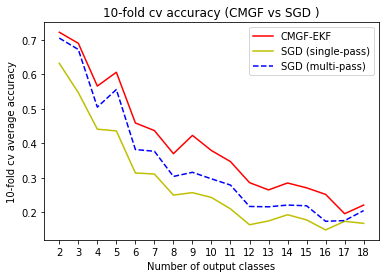

In [8]:
# Plot result
fig, ax = plt.subplots()
ax.plot(class_range, cmgf_accuracies, 'r', label='CMGF-EKF')
ax.plot(class_range, sgd_onepass_accuracies, 'y', label='SGD (single-pass)')
ax.plot(class_range, sgd_multipass_accuracies, 'b--', label='SGD (multi-pass)')
ax.set_xticks(class_range)
ax.set_xlabel('Number of output classes')
ax.set_ylabel(f'{n_splits}-fold cv average accuracy')
ax.set_title(f'{n_splits}-fold cv accuracy (CMGF vs SGD )')
ax.legend();

##3. Speed Comparison with SGD

In [9]:
data_size_grid = list(range(20, 100, 20)) + list(range(100, 1000, 100)) + list(range(1000, 10000, 1000)) \
                 + list(range(10000, 100000, 10000)) + list(range(100000, 1000000, 100000))

In [10]:
cmgf_est = CMGFEstimator(EKFParams)
sgd_op_est = SGDClassifier(loss='log', max_iter=1)
sgd_mp_est = SGDClassifier(loss='log')

# Plot timed results against different dataset sizes
# with fixed class size (K = 3)
import numpy as np
import time

cmgf_times, sgd_op_times, sgd_mp_times = [], [], []

it_times, vec_times = [], []
for data_size in data_size_grid:
    print(f'dataset of size {data_size}')
    simplefilter("ignore", category=ConvergenceWarning)
    input, output = make_classification(n_samples=data_size, n_features=4, n_informative=4, 
                                        n_redundant=0, n_classes=3, random_state=2)
    start = time.time()
    _ = cmgf_est.fit(input, output)
    cmgf_time = time.time() - start
    cmgf_times.append(cmgf_time)
    print(f'cmgf took {cmgf_time} seconds.')

    start = time.time()
    _ = sgd_op_est.fit(input, output)
    sgd_op_time = time.time() - start
    sgd_op_times.append(sgd_op_time)
    print(f'one-pass sgd took {sgd_op_time} seconds.')

    start = time.time()
    _ = sgd_mp_est.fit(input, output)
    sgd_mp_time = time.time() - start
    sgd_mp_times.append(sgd_mp_time)
    print(f'multi-pass sgd took {sgd_mp_time} seconds.')

dataset of size 20
cmgf took 1.1150124073028564 seconds.
one-pass sgd took 0.0021767616271972656 seconds.
multi-pass sgd took 0.0018458366394042969 seconds.
dataset of size 40
cmgf took 1.121196985244751 seconds.
one-pass sgd took 0.00421452522277832 seconds.
multi-pass sgd took 0.0030040740966796875 seconds.
dataset of size 60
cmgf took 1.1277012825012207 seconds.
one-pass sgd took 0.0041201114654541016 seconds.
multi-pass sgd took 0.0036385059356689453 seconds.
dataset of size 80
cmgf took 1.3108961582183838 seconds.
one-pass sgd took 0.0022041797637939453 seconds.
multi-pass sgd took 0.0021457672119140625 seconds.
dataset of size 100
cmgf took 1.047846794128418 seconds.
one-pass sgd took 0.002250194549560547 seconds.
multi-pass sgd took 0.0038504600524902344 seconds.
dataset of size 200
cmgf took 1.0724709033966064 seconds.
one-pass sgd took 0.0022788047790527344 seconds.
multi-pass sgd took 0.004683017730712891 seconds.
dataset of size 300
cmgf took 1.0921356678009033 seconds.
one-

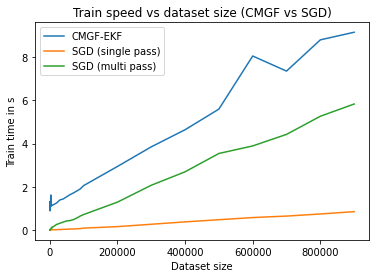

In [11]:
# Plot the result
fig, ax = plt.subplots()
ax.plot(data_size_grid, cmgf_times, label='CMGF-EKF')
ax.plot(data_size_grid, sgd_op_times, label='SGD (single pass)')
ax.plot(data_size_grid, sgd_mp_times, label='SGD (multi pass)')
ax.set_xlabel('Dataset size')
ax.set_ylabel('Train time in s')
ax.set_title('Train speed vs dataset size (CMGF vs SGD)')
ax.legend();
plt.show()

##4. (K-1) CMGF Binary Regressions

Let us try to construct the multinomial logistic regression as a combination of $(K-1)$ binary logistic regressions.

In [12]:
sigmoid_fn = lambda w, x: jax.nn.sigmoid(w @ x)

class CMGFOneVsAllEstimator(BaseEstimator, ClassifierMixin):
    def __init__(self, params, weights=None):
        self.params = params
        self.weights = weights

    def fit(self, X, y):
        X, y = jnp.array(X), jnp.array(y)
        X_bias = jnp.concatenate([jnp.ones((len(X), 1)), X], axis=1)
        input_dim = X_bias.shape[-1]
        num_classes = y.max() + 1

        # Construct CMGFParams
        cmgf_params = self.params(
            initial_mean = jnp.zeros(input_dim),
            initial_covariance = jnp.eye(input_dim),
            dynamics_function = lambda w, x: w,
            dynamics_covariance = jnp.zeros((input_dim, input_dim)),
            emission_mean_function = sigmoid_fn,
            emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))
        )

        # Construct (K-1) binary classifiers
        classifiers = []
        for k in range(num_classes):
            y_k = jnp.array((y == k).astype(float))
            post = conditional_moments_gaussian_filter(cmgf_params, y_k, inputs=X_bias)
            classifiers.append(post.filtered_means[-1])

        self.weights = jnp.array(classifiers)
        return self
    
    def predict(self, X):
        return jnp.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        X = jnp.array(X)
        X_bias = jnp.concatenate([jnp.ones((len(X), 1)), X], axis=1)
        return sigmoid_fn(X_bias, self.weights.T)

Let's examine the speed-up.

In [13]:
cmgf_est = CMGFOneVsAllEstimator(EKFParams)
sgd_op_est = SGDClassifier(loss='log', max_iter=1)
sgd_mp_est = SGDClassifier(loss='log')

# Plot timed results against different dataset sizes
# with fixed class size (K = 3)
import numpy as np
import time

cmgf_times, sgd_op_times, sgd_mp_times = [], [], []

it_times, vec_times = [], []
for data_size in data_size_grid:
    print(f'dataset of size {data_size}')
    simplefilter("ignore", category=ConvergenceWarning)
    input, output = make_classification(n_samples=data_size, n_features=4, n_informative=4, 
                                        n_redundant=0, n_classes=3, random_state=2)
    start = time.time()
    _ = cmgf_est.fit(input, output)
    cmgf_time = time.time() - start
    cmgf_times.append(cmgf_time)
    print(f'cmgf took {cmgf_time} seconds.')

    start = time.time()
    _ = sgd_op_est.fit(input, output)
    sgd_op_time = time.time() - start
    sgd_op_times.append(sgd_op_time)
    print(f'one-pass sgd took {sgd_op_time} seconds.')

    start = time.time()
    _ = sgd_mp_est.fit(input, output)
    sgd_mp_time = time.time() - start
    sgd_mp_times.append(sgd_mp_time)
    print(f'multi-pass sgd took {sgd_mp_time} seconds.')

dataset of size 20
cmgf took 2.070965051651001 seconds.
one-pass sgd took 0.0027878284454345703 seconds.
multi-pass sgd took 0.003916025161743164 seconds.
dataset of size 40
cmgf took 1.8842933177947998 seconds.
one-pass sgd took 0.0031538009643554688 seconds.
multi-pass sgd took 0.003062009811401367 seconds.
dataset of size 60
cmgf took 1.841648817062378 seconds.
one-pass sgd took 0.004082918167114258 seconds.
multi-pass sgd took 0.0030946731567382812 seconds.
dataset of size 80
cmgf took 1.843721866607666 seconds.
one-pass sgd took 0.003793478012084961 seconds.
multi-pass sgd took 0.0027751922607421875 seconds.
dataset of size 100
cmgf took 1.8558037281036377 seconds.
one-pass sgd took 0.0035028457641601562 seconds.
multi-pass sgd took 0.003261566162109375 seconds.
dataset of size 200
cmgf took 1.86561918258667 seconds.
one-pass sgd took 0.0038604736328125 seconds.
multi-pass sgd took 0.0044939517974853516 seconds.
dataset of size 300
cmgf took 1.911578893661499 seconds.
one-pass sgd

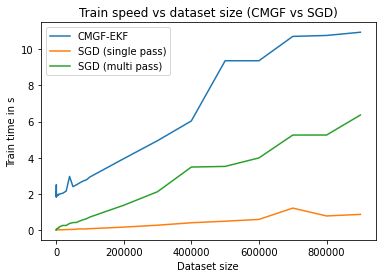

In [14]:
# Plot the result
fig, ax = plt.subplots()
ax.plot(data_size_grid, cmgf_times, label='CMGF-EKF')
ax.plot(data_size_grid, sgd_op_times, label='SGD (single pass)')
ax.plot(data_size_grid, sgd_mp_times, label='SGD (multi pass)')
ax.set_xlabel('Dataset size')
ax.set_ylabel('Train time in s')
ax.set_title('Train speed vs dataset size (CMGF vs SGD)')
ax.legend();
plt.show()

In [15]:
num_points = 1000
class_range = range(2, 19)
n_splits = 5

cmgf_accuracies, sgd_onepass_accuracies, sgd_multipass_accuracies = [], [], []
for num_classes in class_range:
    print(f'{num_points} data points, {num_classes} classes.')
    
    # Initialize estimators
    cmgf_est = CMGFOneVsAllEstimator(EKFParams)
    sgd_op_est = SGDClassifier(loss='log', max_iter=1)
    sgd_mp_est = SGDClassifier(loss='log')
    
    # Compute cv average scores
    cmgf_ac = compute_cv_avg_score(cmgf_est, num_points, num_classes, n_splits=n_splits)
    cmgf_accuracies.append(cmgf_ac)
    print(f'EKF-CMGF estimate average accuracy = {cmgf_ac}')
    sgd_op_ac = compute_cv_avg_score(sgd_op_est, num_points, num_classes, n_splits=n_splits)
    sgd_onepass_accuracies.append(sgd_op_ac)
    print(f'One-pass sgd estimate average accuracy = {sgd_op_ac}')
    sgd_mp_ac = compute_cv_avg_score(sgd_mp_est, num_points, num_classes, n_splits=n_splits)
    sgd_multipass_accuracies.append(sgd_mp_ac)
    print(f'Multi-pass sgd estimate average accuracy = {sgd_mp_ac}')

1000 data points, 2 classes.
EKF-CMGF estimate average accuracy = 0.7190000000000001
One-pass sgd estimate average accuracy = 0.659
Multi-pass sgd estimate average accuracy = 0.6819999999999999
1000 data points, 3 classes.
EKF-CMGF estimate average accuracy = 0.69
One-pass sgd estimate average accuracy = 0.595
Multi-pass sgd estimate average accuracy = 0.654
1000 data points, 4 classes.
EKF-CMGF estimate average accuracy = 0.557
One-pass sgd estimate average accuracy = 0.441
Multi-pass sgd estimate average accuracy = 0.516
1000 data points, 5 classes.
EKF-CMGF estimate average accuracy = 0.601
One-pass sgd estimate average accuracy = 0.46399999999999997
Multi-pass sgd estimate average accuracy = 0.525
1000 data points, 6 classes.
EKF-CMGF estimate average accuracy = 0.4640000000000001
One-pass sgd estimate average accuracy = 0.316
Multi-pass sgd estimate average accuracy = 0.37300000000000005
1000 data points, 7 classes.
EKF-CMGF estimate average accuracy = 0.43299999999999994
One-pass

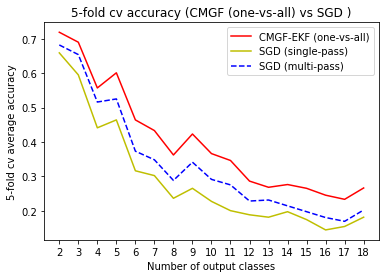

In [16]:
# Plot result
fig, ax = plt.subplots()
ax.plot(class_range, cmgf_accuracies, 'r', label='CMGF-EKF (one-vs-all)')
ax.plot(class_range, sgd_onepass_accuracies, 'y', label='SGD (single-pass)')
ax.plot(class_range, sgd_multipass_accuracies, 'b--', label='SGD (multi-pass)')
ax.set_xticks(class_range)
ax.set_xlabel('Number of output classes')
ax.set_ylabel(f'{n_splits}-fold cv average accuracy')
ax.set_title(f'{n_splits}-fold cv accuracy (CMGF (one-vs-all) vs SGD )')
ax.legend();

#5. Statistical and Computational Efficiency Comparison with SGD

We compare the [statistical and computational efficiencies](https://mc-stan.org/docs/2_22/stan-users-guide/statistical-vs-computational-efficiency.html) of CMGF with those of one-pass and multi-pass SGD.

We use 5-fold CV with `scoring='neg_log_loss'` to compute average log-likelihood score.

In [27]:
data_size_grid = list(range(20, 100, 20)) + list(range(100, 1000, 100)) + list(range(1000, 10000, 1000))

First, we try `num_classes=2`.

In [52]:
num_classes = 2
n_splits = 5

cmgf_logliks, sgd_onepass_logliks, sgd_multipass_logliks = [], [], []
cmgf_times, sgd_op_times, sgd_mp_times = [], [], []
simplefilter("ignore", category=ConvergenceWarning)

for num_points in data_size_grid:
    print(f'{num_points} data points, {num_classes} classes.')
    
    # Initialize estimators
    cmgf_est = CMGFEstimator(EKFParams)
    sgd_op_est = SGDClassifier(loss='log', max_iter=1)
    sgd_mp_est = SGDClassifier(loss='log')
    
    # Compute cv average scores
    start = time.time()
    cmgf_ll = compute_cv_avg_score(cmgf_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    cmgf_time = time.time() - start
    cmgf_logliks.append(cmgf_ll)
    cmgf_times.append(cmgf_time)
    print(f'EKF-CMGF estimate average per-sample log-likelihood = {cmgf_ll}')
    print(f'cmgf took {cmgf_time} seconds.')

    start = time.time()
    sgd_op_ll = compute_cv_avg_score(sgd_op_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    sgd_op_time = time.time() - start
    sgd_onepass_logliks.append(sgd_op_ll)
    sgd_op_times.append(sgd_op_time)
    print(f'One-pass sgd estimate average per-sample log-likelihood = {sgd_op_ll}')
    print(f'one-pass sgd took {sgd_op_time} seconds.')

    start = time.time()
    sgd_mp_ll = compute_cv_avg_score(sgd_mp_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    sgd_mp_time = time.time() - start
    sgd_multipass_logliks.append(sgd_mp_ll)
    sgd_mp_times.append(sgd_mp_time)
    print(f'Multi-pass sgd estimate average per-sample log-likelihood = {sgd_mp_ll}')
    print(f'multi-pass sgd took {sgd_mp_time} seconds.')

150 data points, 2 classes.
EKF-CMGF estimate average per-sample log-likelihood = -0.5900775583585103
cmgf took 4.68778920173645 seconds.
One-pass sgd estimate average per-sample log-likelihood = -4.53335349062879
one-pass sgd took 0.019616127014160156 seconds.
Multi-pass sgd estimate average per-sample log-likelihood = -1.6552696255587602
multi-pass sgd took 0.018758296966552734 seconds.
250 data points, 2 classes.
EKF-CMGF estimate average per-sample log-likelihood = -0.599076651185751
cmgf took 3.8405675888061523 seconds.
One-pass sgd estimate average per-sample log-likelihood = -4.4330372174323545
one-pass sgd took 0.017893314361572266 seconds.
Multi-pass sgd estimate average per-sample log-likelihood = -0.9463959750659274
multi-pass sgd took 0.022630691528320312 seconds.
350 data points, 2 classes.
EKF-CMGF estimate average per-sample log-likelihood = -0.5810717230609485
cmgf took 4.656940698623657 seconds.
One-pass sgd estimate average per-sample log-likelihood = -3.1583693215500

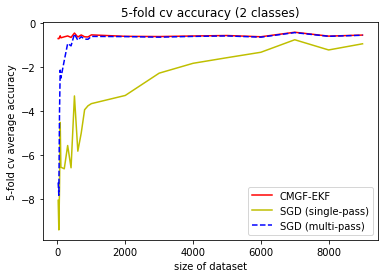

In [39]:
# Plot result
fig, ax = plt.subplots()
ax.plot(data_size_grid, cmgf_logliks, 'r', label='CMGF-EKF')
ax.plot(data_size_grid, sgd_onepass_logliks, 'y', label='SGD (single-pass)')
ax.plot(data_size_grid, sgd_multipass_logliks, 'b--', label='SGD (multi-pass)')
ax.set_xlabel('size of dataset')
ax.set_ylabel(f'{n_splits}-fold cv average accuracy')
ax.set_title(f'{n_splits}-fold cv accuracy ({num_classes} classes)')
ax.legend();

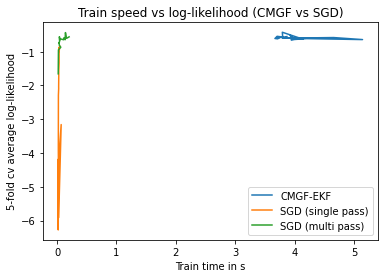

In [53]:
# Plot the result
fig, ax = plt.subplots()
ax.plot(cmgf_times, cmgf_logliks, label='CMGF-EKF')
ax.plot(sgd_op_times, sgd_onepass_logliks, label='SGD (single pass)')
ax.plot(sgd_mp_times, sgd_multipass_logliks, label='SGD (multi pass)')
ax.set_xlabel('Train time in s')
ax.set_ylabel(f'{n_splits}-fold cv average log-likelihood')
ax.set_title('Train speed vs log-likelihood (CMGF vs SGD)')
ax.legend();
plt.show()

Next, we try 4 classes

In [44]:
data_size_grid = list(range(60, 100, 20)) + list(range(100, 1000, 100)) + list(range(1000, 10000, 1000))

In [45]:
num_classes = 4
n_splits = 5

cmgf_logliks, sgd_onepass_logliks, sgd_multipass_logliks = [], [], []
simplefilter("ignore", category=ConvergenceWarning)
for num_points in data_size_grid:
    print(f'{num_points} data points, {num_classes} classes.')
    
    # Initialize estimators
    cmgf_est = CMGFEstimator(EKFParams)
    sgd_op_est = SGDClassifier(loss='log', max_iter=1)
    sgd_mp_est = SGDClassifier(loss='log')
    
    # Compute cv average scores
    cmgf_ll = compute_cv_avg_score(cmgf_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    cmgf_logliks.append(cmgf_ll)
    print(f'EKF-CMGF estimate average per-sample log-likelihood = {cmgf_ll}')
    sgd_op_ll = compute_cv_avg_score(sgd_op_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    sgd_onepass_logliks.append(sgd_op_ll)
    print(f'One-pass sgd estimate average per-sample log-likelihood = {sgd_op_ll}')
    sgd_mp_ll = compute_cv_avg_score(sgd_mp_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    sgd_multipass_logliks.append(sgd_mp_ll)
    print(f'Multi-pass sgd estimate average per-sample log-likelihood = {sgd_mp_ll}')

60 data points, 4 classes.
EKF-CMGF estimate average per-sample log-likelihood = -1.3658468030393123
One-pass sgd estimate average per-sample log-likelihood = -13.751871568727125
Multi-pass sgd estimate average per-sample log-likelihood = -8.933542245564537
80 data points, 4 classes.
EKF-CMGF estimate average per-sample log-likelihood = -1.1990131072700023
One-pass sgd estimate average per-sample log-likelihood = -10.820047870845253
Multi-pass sgd estimate average per-sample log-likelihood = -8.382061818167523
100 data points, 4 classes.
EKF-CMGF estimate average per-sample log-likelihood = -1.1242235231399538
One-pass sgd estimate average per-sample log-likelihood = -11.665687874186316
Multi-pass sgd estimate average per-sample log-likelihood = -6.9021825496079545
200 data points, 4 classes.
EKF-CMGF estimate average per-sample log-likelihood = -1.0761162827163935
One-pass sgd estimate average per-sample log-likelihood = -12.44146026823677
Multi-pass sgd estimate average per-sample lo

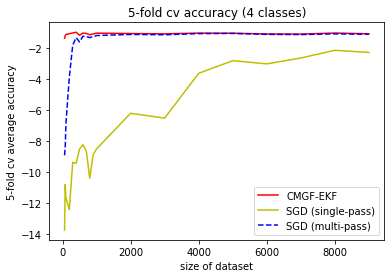

In [46]:
# Plot result
fig, ax = plt.subplots()
ax.plot(data_size_grid, cmgf_logliks, 'r', label='CMGF-EKF')
ax.plot(data_size_grid, sgd_onepass_logliks, 'y', label='SGD (single-pass)')
ax.plot(data_size_grid, sgd_multipass_logliks, 'b--', label='SGD (multi-pass)')
ax.set_xlabel('size of dataset')
ax.set_ylabel(f'{n_splits}-fold cv average accuracy')
ax.set_title(f'{n_splits}-fold cv accuracy ({num_classes} classes)')
ax.legend();

Finally, we try 10 classes.

In [49]:
data_size_grid = list(range(150, 1000, 100)) + list(range(1000, 10000, 1000))

In [50]:
num_classes = 10
n_splits = 5

cmgf_logliks, sgd_onepass_logliks, sgd_multipass_logliks = [], [], []
simplefilter("ignore", category=ConvergenceWarning)
for num_points in data_size_grid:
    print(f'{num_points} data points, {num_classes} classes.')
    
    # Initialize estimators
    cmgf_est = CMGFEstimator(EKFParams)
    sgd_op_est = SGDClassifier(loss='log', max_iter=1)
    sgd_mp_est = SGDClassifier(loss='log')
    
    # Compute cv average scores
    cmgf_ll = compute_cv_avg_score(cmgf_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    cmgf_logliks.append(cmgf_ll)
    print(f'EKF-CMGF estimate average per-sample log-likelihood = {cmgf_ll}')
    sgd_op_ll = compute_cv_avg_score(sgd_op_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    sgd_onepass_logliks.append(sgd_op_ll)
    print(f'One-pass sgd estimate average per-sample log-likelihood = {sgd_op_ll}')
    sgd_mp_ll = compute_cv_avg_score(sgd_mp_est, num_points, num_classes, n_splits=n_splits, scoring='neg_log_loss')
    sgd_multipass_logliks.append(sgd_mp_ll)
    print(f'Multi-pass sgd estimate average per-sample log-likelihood = {sgd_mp_ll}')

150 data points, 10 classes.
EKF-CMGF estimate average per-sample log-likelihood = -2.220562877940635
One-pass sgd estimate average per-sample log-likelihood = -20.61958856188619
Multi-pass sgd estimate average per-sample log-likelihood = -13.773794588066433
250 data points, 10 classes.
EKF-CMGF estimate average per-sample log-likelihood = -2.2777299651801584
One-pass sgd estimate average per-sample log-likelihood = -24.057289260994956
Multi-pass sgd estimate average per-sample log-likelihood = -9.455163039021736
350 data points, 10 classes.
EKF-CMGF estimate average per-sample log-likelihood = -2.042834940701723
One-pass sgd estimate average per-sample log-likelihood = -22.041087097961224
Multi-pass sgd estimate average per-sample log-likelihood = -5.842910608320743
450 data points, 10 classes.
EKF-CMGF estimate average per-sample log-likelihood = -1.8853543150011038
One-pass sgd estimate average per-sample log-likelihood = -20.313683275905962
Multi-pass sgd estimate average per-sampl

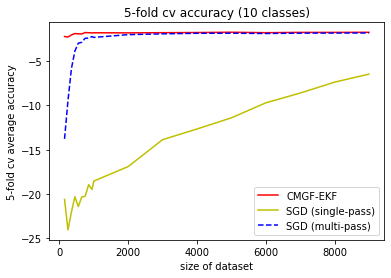

In [51]:
# Plot result
fig, ax = plt.subplots()
ax.plot(data_size_grid, cmgf_logliks, 'r', label='CMGF-EKF')
ax.plot(data_size_grid, sgd_onepass_logliks, 'y', label='SGD (single-pass)')
ax.plot(data_size_grid, sgd_multipass_logliks, 'b--', label='SGD (multi-pass)')
ax.set_xlabel('size of dataset')
ax.set_ylabel(f'{n_splits}-fold cv average accuracy')
ax.set_title(f'{n_splits}-fold cv accuracy ({num_classes} classes)')
ax.legend();